## NHL Season Playoff Outcome Logistic Regression EDA

### Description

The following EDA analysis explores NHL team season data from 1983 to 2021 to predict playoff outcomes by adjusted games a team wins **(wins + (ties / 2))** above the average adjusted wins of any given season (positive variance). 

More than 60% of teams make the playoffs, so the logistic regression sets out to predict teams that don't make the playoffs. 

The entirety of this analysis seeks to understand the statistical economics of what team organizations need to achieve to make playoffs by understanding the economics of what doesn't work to make playoffs. As a result, team organizations can gain more transparency and perspective on what may help in strategizing for successful campaigns.

In [1]:
# Import libraries
import psycopg2 as ps
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
from scipy.stats.mstats import normaltest

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from Preprocessing_Functions import *
from pickle import dump
from pickle import load

### Data Preprocessing and Feature Engineering

In [2]:
# Connect to database and get nhl_view
try:
    conn = ps.connect('''host=localhost
                         dbname=nhldb
                         user=postgres
                         password=iEchu133
                         ''')
    cur = conn.cursor()

    print('Successfully connected to nhldb.')

except ps.Error as e:
    print('\n Database Error:')
    print(e)
    
query = '''SELECT *
           FROM nhl_view;'''

cur.execute(query)
nhl_df = cur.fetchall()
col_names = [
    'team',
    'season_year_range',
    'games_played',
    'wins',
    'losses',
    'ot',
    'pts',
    'pt_pctg',
    'goals_per_game',
    'goals_against_per_game',
    'evgga_ratio',
    'power_play_percentage',
    'power_play_goals',
    'power_play_goals_against',
    'power_play_opportunities',
    'penalty_kill_percentage',
    'shots_per_game',
    'shots_allowed',
    'win_score_first',
    'win_opp_score_first',
    'win_lead_first_per',
    'win_lead_second_per',
    'win_outshoot_opp',
    'win_outshot_by_opp',
    'face_offs_taken',
    'face_offs_won',
    'face_offs_lost',
    'face_off_win_percentage',
    'shooting_pctg',
    'save_pctg',
    'failed_shots_per_game',
    'saves_per_game',
    'ties',
    'power_play_efficiency',
    'made_playoffs',
    'adjWins'
]

nhl_df = pd.DataFrame(nhl_df, columns = col_names)

conn.close()

# Claculate and remove adjusted wins outliers
outliers = remove_outliers(df = nhl_df, col = 'adjWins')

nhl_df = nhl_df.loc[(nhl_df['adjWins'] > outliers[1]) & (nhl_df['adjWins'] < outliers[3])].reset_index(drop = True)

nhl_df.info()
nhl_df.head()

Successfully connected to nhldb.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   team                      922 non-null    object 
 1   season_year_range         922 non-null    int64  
 2   games_played              922 non-null    int64  
 3   wins                      922 non-null    int64  
 4   losses                    922 non-null    int64  
 5   ot                        922 non-null    int64  
 6   pts                       922 non-null    int64  
 7   pt_pctg                   922 non-null    float64
 8   goals_per_game            922 non-null    float64
 9   goals_against_per_game    922 non-null    float64
 10  evgga_ratio               922 non-null    float64
 11  power_play_percentage     922 non-null    float64
 12  power_play_goals          922 non-null    int64  
 13  power_play_goals_against  922 no

,team,season_year_range,games_played,wins,losses,ot,pts,pt_pctg,goals_per_game,goals_against_per_game,evgga_ratio,power_play_percentage,power_play_goals,power_play_goals_against,power_play_opportunities,penalty_kill_percentage,shots_per_game,shots_allowed,win_score_first,win_opp_score_first,win_lead_first_per,win_lead_second_per,win_outshoot_opp,win_outshot_by_opp,face_offs_taken,face_offs_won,face_offs_lost,face_off_win_percentage,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game,ties,power_play_efficiency,made_playoffs,adjWins
0,New Jersey Devils,19831984,80,17,56,0,41,25.6,2.888,4.375,0.6780,14.3,52,83,363,75.3,26.3875,32.0000,0.464,0.077,0.571,0.765,0.348,0.188,0,0,0,0.0,10.9,0.863,23.511263,27.616000,7,-0.085399,0,20.5
1,New York Islanders,19831984,80,50,26,0,104,65.0,4.463,3.363,1.3722,22.5,63,66,280,81.5,30.2750,33.3875,0.791,0.432,0.853,0.933,0.857,0.532,0,0,0,0.0,14.7,0.899,25.824575,30.015363,4,-0.010714,1,52.0
2,New York Rangers,19831984,80,42,29,0,93,58.1,3.925,3.800,1.0392,25.1,74,76,295,78.1,31.8875,31.5500,0.619,0.421,0.828,0.969,0.675,0.467,0,0,0,0.0,12.3,0.880,27.965338,27.764000,9,-0.006780,1,46.5
3,Philadelphia Flyers,19831984,80,44,26,0,98,61.3,4.375,3.625,1.3646,20.2,64,85,317,76.6,36.7500,28.6500,0.667,0.400,0.813,0.875,0.720,0.286,0,0,0,0.0,11.9,0.873,32.376750,25.011450,10,-0.066246,1,49.0
4,Pittsburgh Penguins,19831984,80,16,58,0,38,23.8,3.175,4.875,0.6466,20.9,71,86,339,76.0,28.3375,36.3500,0.316,0.095,0.421,0.737,0.364,0.183,0,0,0,0.0,11.2,0.866,25.163700,31.479100,6,-0.044248,0,19.0


The above code imports the original data for seasons 1983 - 2021. 

Additional features were derived during the ETL stage in the data life cycle:

* **Failed shots per game (failed_shots_per_game)** - Shots that did not translate into goals.<br><br>
* **Saves per game (saves_per_game)** - Shots against that did not translate into goals against.<br><br>
* **Ties per season (ties)** - (total games per season - (wins + losses)).<br><br>
* **Adjusted wins (adjWins)** - (total wins + (ties / 2)).<br><br>
* **Powerplay Efficiency (power_play_efficiency)** - (powerplay goals for - powerplay goals against) / powerplay opportunities.<br>

In [3]:
# Import NHL team season stats data frame
yearly_mean = nhl_df.copy()
yearly_mean = yearly_mean[[ 'season_year_range', 'adjWins']]

# Group by year range and average the adjusted wins per year range
yearly_mean = yearly_mean.groupby(by = ['season_year_range']).mean().reset_index()
yearly_mean.columns = ['season_year_range', 'avgAdjWins']

# Print data summary
print('\n')
yearly_mean.info()
yearly_mean.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_year_range  37 non-null     int64  
 1   avgAdjWins         37 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 720.0 bytes


,season_year_range,avgAdjWins
0,19831984,39.970588
1,19841985,40.058824
2,19851986,40.000000
3,19861987,39.911765
4,19871988,41.352941


To derive our target variable **(adjusted wins above the mean of individual seasons)**, the average adjusted wins per season (year_range) is calculated.

Outliers for Adjusted wins are removed before the mean is calculated.

In [4]:
# Merge two data frames
nhl_df = nhl_df.merge(yearly_mean, on = 'season_year_range')

# Calculate target variable
nhl_df['aboveAvgAdjWins'] = nhl_df['adjWins'] - nhl_df['avgAdjWins']

# Remove unneeded features
nhl_df_y = nhl_df.copy()

drop_cols = [
    'adjWins', 
    'avgAdjWins', 
    'made_playoffs'
]

nhl_df = nhl_df.drop(
    drop_cols, 
    axis = 1, 
    errors = 'ignore'
)

# Multiply savePctg by 100 to get percent
nhl_df['save_pctg'] = nhl_df['save_pctg'] * 100

# Print data summary
print('\n')
nhl_df.info()
nhl_df.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 922 entries, 0 to 921
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   team                      922 non-null    object 
 1   season_year_range         922 non-null    int64  
 2   games_played              922 non-null    int64  
 3   wins                      922 non-null    int64  
 4   losses                    922 non-null    int64  
 5   ot                        922 non-null    int64  
 6   pts                       922 non-null    int64  
 7   pt_pctg                   922 non-null    float64
 8   goals_per_game            922 non-null    float64
 9   goals_against_per_game    922 non-null    float64
 10  evgga_ratio               922 non-null    float64
 11  power_play_percentage     922 non-null    float64
 12  power_play_goals          922 non-null    int64  
 13  power_play_goals_against  922 non-null    int64  
 14  power_pl

,team,season_year_range,games_played,wins,losses,ot,pts,pt_pctg,goals_per_game,goals_against_per_game,evgga_ratio,power_play_percentage,power_play_goals,power_play_goals_against,power_play_opportunities,penalty_kill_percentage,shots_per_game,shots_allowed,win_score_first,win_opp_score_first,win_lead_first_per,win_lead_second_per,win_outshoot_opp,win_outshot_by_opp,face_offs_taken,face_offs_won,face_offs_lost,face_off_win_percentage,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game,ties,power_play_efficiency,aboveAvgAdjWins
0,New Jersey Devils,19831984,80,17,56,0,41,25.6,2.888,4.375,0.6780,14.3,52,83,363,75.3,26.3875,32.0000,0.464,0.077,0.571,0.765,0.348,0.188,0,0,0,0.0,10.9,86.3,23.511263,27.616000,7,-0.085399,-19.470588
1,New York Islanders,19831984,80,50,26,0,104,65.0,4.463,3.363,1.3722,22.5,63,66,280,81.5,30.2750,33.3875,0.791,0.432,0.853,0.933,0.857,0.532,0,0,0,0.0,14.7,89.9,25.824575,30.015363,4,-0.010714,12.029412
2,New York Rangers,19831984,80,42,29,0,93,58.1,3.925,3.800,1.0392,25.1,74,76,295,78.1,31.8875,31.5500,0.619,0.421,0.828,0.969,0.675,0.467,0,0,0,0.0,12.3,88.0,27.965338,27.764000,9,-0.006780,6.529412
3,Philadelphia Flyers,19831984,80,44,26,0,98,61.3,4.375,3.625,1.3646,20.2,64,85,317,76.6,36.7500,28.6500,0.667,0.400,0.813,0.875,0.720,0.286,0,0,0,0.0,11.9,87.3,32.376750,25.011450,10,-0.066246,9.029412
4,Pittsburgh Penguins,19831984,80,16,58,0,38,23.8,3.175,4.875,0.6466,20.9,71,86,339,76.0,28.3375,36.3500,0.316,0.095,0.421,0.737,0.364,0.183,0,0,0,0.0,11.2,86.6,25.163700,31.479100,6,-0.044248,-20.970588


The complete data set is generated.

In [5]:
# Retain failed_playoff_flag in a separate data frame
nhl_df_y['missed_playoffs'] = np.where(nhl_df_y['made_playoffs'] == 1, 0, 1)
nhl_df_y = nhl_df_y[['missed_playoffs']]

# Print data summary
print('\n')
nhl_df_y.info()
nhl_df_y.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 922 entries, 0 to 921
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   missed_playoffs  922 non-null    int32
dtypes: int32(1)
memory usage: 10.8 KB


,missed_playoffs
0,1
1,0
2,0
3,0
4,1


The missed_playoffs target variable is retained as its own data frame called nhl_df_y to be the y values predicted in the logistic regression.

In [6]:
# Retain the aboveAvgAdjWins data in a separate data frame
nhl_df_X = nhl_df[['aboveAvgAdjWins']]

# Print data summary
print('\n')
nhl_df_X.info()
nhl_df_X.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 922 entries, 0 to 921
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   aboveAvgAdjWins  922 non-null    float64
dtypes: float64(1)
memory usage: 14.4 KB


,aboveAvgAdjWins
0,-19.470588
1,12.029412
2,6.529412
3,9.029412
4,-20.970588


The aboveAvgAdjWins will be used as the X values in the logistic regression.

In [7]:
# Concatenate all data frames
nhl_df = pd.concat([nhl_df_X, nhl_df_y], axis = 1)

# Print data summary
print('\n')
nhl_df.info()
nhl_df.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 922 entries, 0 to 921
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   aboveAvgAdjWins  922 non-null    float64
 1   missed_playoffs  922 non-null    int32  
dtypes: float64(1), int32(1)
memory usage: 18.0 KB


,aboveAvgAdjWins,missed_playoffs
0,-19.470588,1
1,12.029412,0
2,6.529412,0
3,9.029412,0
4,-20.970588,1


The nhl_df contains the predicted predAboveAvgAdjWins feature and missed_playoffs target variable.

### Data Exploration and Selection

#### Univariate Analysis

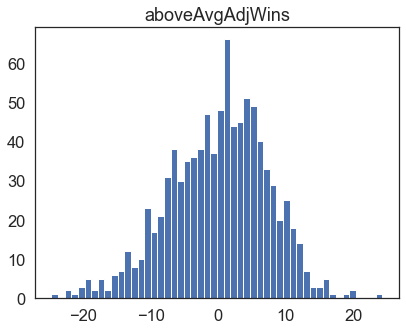


X continuous descriptive stats:


,count,mean,std,min,25%,50%,75%,max
aboveAvgAdjWins,922.0,-1.618373e-16,7.333648,-24.717391,-4.911765,0.660256,5.086207,24.3125



normality test:

statistic: 0.0
p-value: 13.71



In [13]:
# aboveAvgAdjWins distribution
y_hist = nhl_df.copy()
y_hist = y_hist[['aboveAvgAdjWins']]

num_univariate_histogram(
    df = nhl_df, 
    length = 5,
    width = 15, 
    rows = 1, 
    col = 2, 
    font = 1.5, 
    kind = 1
)

print(
    '\n' + 'normality test:' +  '\n' + '\n' + 'statistic: ' + 
    str(round(normaltest(y_hist['aboveAvgAdjWins'].values)[1], 2)) +
    '\n' + 'p-value: ' + str(round(normaltest(y_hist['aboveAvgAdjWins'].values)[0],2)) + '\n'
)

The aboveAvgAdjWins feature appears to be normally distributed.

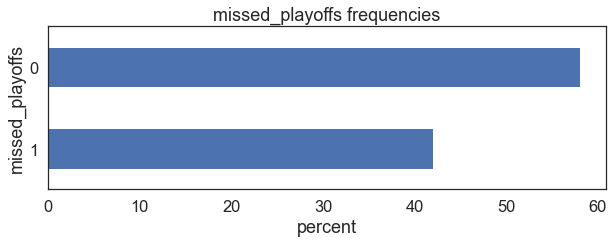

In [9]:
# Retaine missed_playoffs in a separate data frame
cat_df = nhl_df[['missed_playoffs']].astype(str)

# missed_playoffs frequency
cat_univariate_freq(
    df = cat_df, 
    length = 3, 
    width = 10, 
    col_start = 0, 
    col_end = 1, 
    font = 1.5
)

The above shows the frequencies of playoff outcomes for the tears of study (1983-2021).

#### Bivariate Analysis

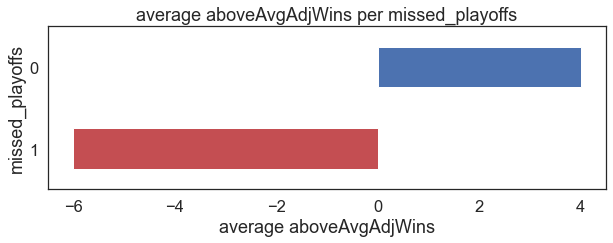

,aboveAvgAdjWins,positive
missed_playoffs,,
0,4.0,True
1,-6.0,False


In [10]:
# Convert missed_playoffs to string data type
nhl_df['missed_playoffs'] = nhl_df['missed_playoffs'].astype(str)

# View averages per playoff outcome
cat_bivariate_avg_target(
    df = nhl_df, 
    col_start = 0, 
    col_end = 1, 
    target = 'aboveAvgAdjWins', 
    length = 3, 
    width = 10, 
    font = 1.5
)

The above shows the bivariate comparison between missed_playoffs and average aboveAvgAdjWins.

In [11]:
# Export final data frame to project directory
nhl_df.to_csv('Data/NHL_1983_2021_Playoff_Data_Removed_Outliers.csv', index = False)

The final data frame is exported to the project directory for further analysis.